In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji
from matplotlib import pyplot as plt
import math
from joblib import dump, load

stop_words = set(stopwords.words("english"))


In [2]:
fn = "group_8_automotive_data.csv"
data = pd.read_csv(fn, encoding='utf-8')

In [3]:
from nltk.corpus import wordnet

def negate(sentence):	
  '''
  Input: Tokenized sentence (List of words)
  Output: Tokenized sentence with negation handled (List of words)
  '''
  temp = int(0)
  for i in range(len(sentence)):
      if sentence[i-1] in ['not',"n't"]:
          antonyms = []
          for syn in wordnet.synsets(sentence[i]):
              syns = wordnet.synsets(sentence[i])
              w1 = syns[0].name()
              temp = 0
              for l in syn.lemmas():
                  if l.antonyms():
                      antonyms.append(l.antonyms()[0].name())
              max_dissimilarity = 0
              for ant in antonyms:
                  syns = wordnet.synsets(ant)
                  w2 = syns[0].name()
                  syns = wordnet.synsets(sentence[i])
                  w1 = syns[0].name()
                  word1 = wordnet.synset(w1)
                  word2 = wordnet.synset(w2)
                  if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                      temp = 1 - word1.wup_similarity(word2)
                  if temp>max_dissimilarity:
                      max_dissimilarity = temp
                      antonym_max = ant
                      sentence[i] = antonym_max
                      sentence[i-1] = ''
  while '' in sentence:
      sentence.remove('')
  return sentence

negate(["not", "good"])

['evil']

In [3]:
def negate(value):
    result = []
    i = 0
    while i < len(value):
        if i < len(value) - 1 and value[i] in ["not", "no"]:
            result.append(("not " + value[i + 1]).strip())
            i += 2
        else:
            result.append(value[i])
            i += 1
    return result

In [456]:
def cleanly_tokenize(text):
  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  
  # Remove HTML tags by getting parsed text
  text = BeautifulSoup(text, "html.parser").get_text()

  # Replace Markdown-like
  text = re.sub(r"\[\[.*\]\]", "", text)

  # Replace "n't" with " not"
  text = re.sub(r"n't", " not", text)

  # Remove non-letters (except emojis) and lowercase 
  pattern = r'[^a-zA-Z0-9\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+'
  text = re.sub(pattern, " ", text).lower()
  
  # Replace emojis with text representation
  text = emoji.demojize(text, [" emoji_", " "])

  # Tokenize
  tokens = word_tokenize(text)

  # Remove stopwords
  tokens = [i for i in tokens if i not in stop_words or i in ["not"]]
  
  # Remove tokens with numbers
  tokens = [i for i in tokens if not any(c.isdigit() for c in i)]

  # Handle negation
  tokens = negate(tokens)

  # Remove tokens of length 1
  tokens = [i for i in tokens if len(i) > 1]

  # Stem
  stemmer = nltk.WordNetLemmatizer()
  tokens = [stemmer.lemmatize(i) for i in tokens]

  return tokens


In [457]:
cleanly_tokenize("Unlike some of the other Hillary for Prison bumper stickers, this one is easy to 17mm read by other vehicles.  You don't want to be accidentally confused for a Hillary supporter, do you.")

['unlike',
 'hillary',
 'prison',
 'bumper',
 'sticker',
 'one',
 'easy',
 'read',
 'vehicle',
 'not want',
 'accidentally',
 'confused',
 'hillary',
 'supporter']

In [24]:
# find all rows that have emoji in review_body
data[data['review_body'].str.contains('[\U0001F600-\U0001F6FF]')]["review_body"].sample(10).values

array(['Makes the impossible Possible!!!😃 This says it all! Spray it on the decal mounting side, spray it on the vehicle mounting surface, position decal on vehicle, spray Rapid-Tac on top of decal to lubricate for squeegee, and begin to squeegee out the air bubbles and excess Rapid-Tac from trapped between the decal and mounting surface. Do this quickly as there is about a 2 minute window before the Rapid-Tac begins to grab. Wipe surrounding overspray off using microfiber towel and wait approximately 1 hour before peeling off transfer paper at a sharp angle to the mounting surface.',
       '👍👌🚘🚘',
       "What a fun way to kill pests!! Got this for my husband, who has an affinity for swatting all things airborne. Gave it to him last night & I think he actually fell asleep with it in his hand😂.<br />No really, I don't think he's put it down since I handed it to him. It works for the most part from what he's said. He does not recommend going after wasps with it, however- &#34;they have

In [344]:
def get_review_body(review_id):
  return [word for word in cleanly_tokenize(data.loc[data["review_id"] == review_id]["review_body"].values[0]) if word in words]

get_review_body("RLO2HPKLQ6KFB")

['unlike',
 'bumper',
 'sticker',
 'one',
 'easy',
 'read',
 'vehicle',
 'not want',
 'accidentally',
 'confused']

In [48]:
trunc = data.sample(70000)
trunc.head(3)

,customer_id,review_id,product_id,product_title,product_category,star_rating,verified_purchase,review_body
273270,29439986,R3UV963UFDHHKT,B002J854UC,Meguiar's Heavy Duty Headlight Restoration Kit.16,Automotive,5,Y,The sealant really works! I couldn't believe i...
9045,25139801,RN4EZYE94J2TH,B0032YUKMY,Lebra 2 piece Front End Cover Black - Car Mask...,Automotive,1,N,Wife got me one for our aniversary. This bra h...
366875,520456,R31TBK3J3R4YWJ,B004S3PH9Y,Ford F250/F350/F450/F550/Super DutyPick Up Tru...,Automotive,3,Y,It show to be black and silver


In [458]:
# give me 10k random one star reviews

verified_data = data[data["verified_purchase"] == "Y"]

def get_by_star(star, n):
    return verified_data[verified_data["star_rating"] == star].sample(math.ceil(n))


def get_weights(t):
    base = [
        0.085047405,
        0.0387409,
        0.062817448,
        0.136370552,
        0.677023695,
    ]

    return [i * (1 - t) + 0.2 * t for i in base]


# using get_by_star give me one dataframe with equal amounts of star reviews
def get_equal_star(n, t):
    weights = get_weights(t)
    one = get_by_star(1, n * weights[0])
    two = get_by_star(2, n * weights[1])
    three = get_by_star(3, n * weights[2])
    four = get_by_star(4, n * weights[3])
    five = get_by_star(5, n * weights[4])
    return pd.concat([one, two, three, four, five]).sample(n)


# get data rows not in trunc
def get_not_trunc(trunc):
    return data.loc[~data["review_id"].isin(trunc["review_id"])]


def get_data(n, k, t):
    train = get_equal_star(n, t)
    print(train["star_rating"].value_counts())
    test = get_not_trunc(train).sample(k)
    return pd.concat([train, test])


n_train = 80000
n_test = 20000

trunc = get_data(n_train, n_test, 0.6)


5    31263
4    13964
1    12322
3    11611
2    10840
Name: star_rating, dtype: int64


In [459]:
from pandas import Series


vectorizer = TfidfVectorizer(
  # stop_words="english", 
  # strip_accents="unicode", 
  # lowercase=True, 
  tokenizer=cleanly_tokenize,
  ngram_range=(1, 1), 
  max_features=10000
)
counts_train = vectorizer.fit_transform(trunc[:n_train]["review_body"]).toarray()
words = vectorizer.get_feature_names_out()
X_train = pd.DataFrame(counts_train, columns=words)
print(words)

counts_test = vectorizer.transform(trunc[n_train:]["review_body"]).toarray()
X_test = pd.DataFrame(counts_test, columns=words)

c:\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Qcoret\AppData\Roaming\Python\Python310\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


['aa' 'aaa' 'aaaa' ... 'zuma' 'zumo' 'zxe']


C:\Users\Qcoret\AppData\Roaming\Python\Python310\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [14]:
trunc[:n_train]["review_body"]

107033                                            Excellent
312123    It was a fair price but keeps falling down. Fo...
80276                            Cannot connect with iphone
106344    This was exactly what I needed for my 95 Infin...
157897    Fits Great.  Needs a couple more attachment ta...
                                ...                        
457379    A must have to protect wear and tear on your 4...
92004     Very small - thought it would be larger - but ...
293774    Nothing like what I expected. I am note sure w...
424249    Everything fit right on my 2000.  Only bad I h...
408002    made my jeep and lights look just like new. ha...
Name: review_body, Length: 50000, dtype: object

In [487]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from joblib import load

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

y_train = trunc["star_rating"][:n_train]
y_test  = trunc["star_rating"][n_train:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print("scaled fit")
X_test_scaled = scaler.transform(X_test)
print("scaled transform")

pca = PCA(n_components=1000)  # Choose the desired number of components
X_train_pca = pca.fit_transform(X_train_scaled)
print("pca fit")
X_test_pca = pca.transform(X_test_scaled)
print("pca transform")

classifier = MultinomialNB(alpha=1)
classifier.fit(X_train_pca, y_train)

print("fit")
# classifier = load("50k_10k_logistic_75pc.joblib")

predictions = classifier.predict(X_test_pca)
print("predict")


scaled fit
scaled transform


MemoryError: Unable to allocate 5.96 GiB for an array with shape (80000, 10000) and data type float64

In [17]:

dump(classifier, "50k_10k_logistic_75pc.joblib")

['50k_10k_logistic_75pc.joblib']

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score

print("Accuracy", accuracy_score(y_test, predictions))
print("RMSE", mean_squared_error(y_test, predictions, squared=False))
print("MEA", mean_absolute_error(y_test, predictions))
print("F1", f1_score(y_test, predictions, average='macro'))

NameError: name 'y_test' is not defined

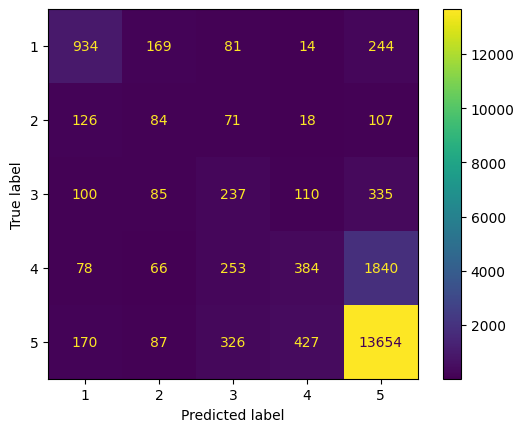

In [462]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

plt.show()

In [486]:
import random

# Define the number of random rows to view
n = 5

# Get random indices from the test set
random_idx = round(random.random() * n_test)


# Retrieve the corresponding sample and its information
sample_text = trunc[n_train:].iloc[random_idx]['review_body']
sample_tokenized = [w for w in cleanly_tokenize(sample_text) if w in words]
sample_real_stars = y_test.iloc[random_idx] 
sample_predicted_stars = predictions[random_idx]  
# sample_is_verified = trunc.iloc[X_test.index[random_idx]]['verified_purchase'] == 'Y'

# Print the sample information
print("Sample Text:", sample_text)
print("Tokenized Text:", sample_tokenized)
print("Real Stars:", sample_real_stars)
print("Predicted Stars:", sample_predicted_stars)

Sample Text: I have them under the dash of my Jeep.  The diffuser does block some of the light (so not as bright as I'd hoped) but it is spread pretty even (not like a spot light shining down from under the dash).
Tokenized Text: ['dash', 'jeep', 'diffuser', 'block', 'light', 'not bright', 'hoped', 'spread', 'pretty', 'even', 'not like', 'spot', 'light', 'shining', 'dash']
Real Stars: 3
Predicted Stars: 3


In [47]:
X_test.index[random_idx]

5257

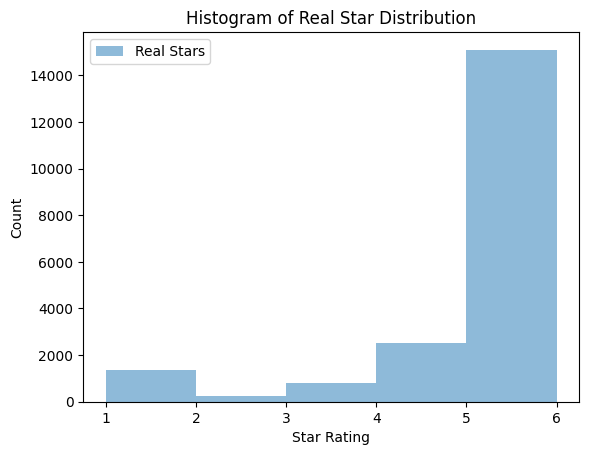

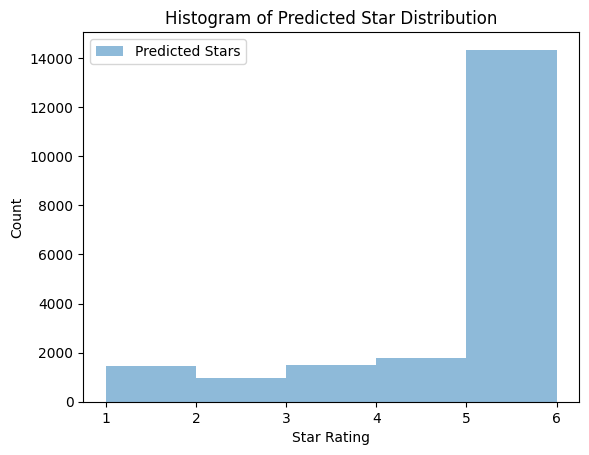

In [338]:
# Plot the histogram of real star distribution
plt.hist(y_test, bins=5, range=(1, 6), alpha=0.5, label='Real Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Real Star Distribution')
plt.legend()
plt.show()

# Plot the histogram of predicted star distribution
plt.hist(predictions, bins=5, range=(1, 6), alpha=0.5, label='Predicted Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Predicted Star Distribution')
plt.legend()
plt.show()


In [15]:
stars = data['star_rating']
print(len(stars.loc[stars == 1]))
print(len(stars.loc[stars == 2]))
print(len(stars.loc[stars == 3]))
print(len(stars.loc[stars == 4]))
print(len(stars.loc[stars == 5]))

40807
18588
30140
65431
324838


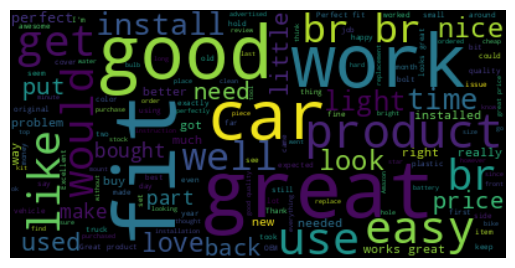

In [20]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

textt = " ".join(review for review in trunc['review_body'])
wordcloud = WordCloud(stopwords=stopwords.words()).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\Qcoret\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [19]:
def readFile(fileName):
  #Reads the file, the proper encoding is to prevent problems
  return pd.read_csv(fileName, encoding="utf−8")

In [21]:
punctuation = string.punctuation

def cleanData(data):
  #Replace missing data with "" in product_title
  data["product_title"] = data["product_title"].fillna("")

  n = len(data["review_body"])
  #for i in np.arange(n):
  #  data["review_body"][i] = BeautifulSoup(data["review_body"][i], "html.parser")

  #Remove the capital letters to prevent miscounting the frequency of words
  data["review_body"] = data["review_body"].str.lower()

  #Remove punctuation so that we can later split the data properly into words by only consider spaces
  data["review_body"] = data["review_body"].apply(lambda data: removePunctuation(data))

  testData = data["review_body"][0:100]
 
  stopwords = set(stopwords.words("english"))
  doc_string = testData.loc[0, "text"]
  print(doc_string)
  


def removePunctuation(text):
    return text.translate(str.maketrans('', '', punctuation))


In [22]:
def main():
  file = readFile("group_8_automotive_data.csv")
  #print(file.head())

  #Results below show that approximately all data is inserted,
  #except for product_title where approximately 0.0015% is missing
  #print(file.isnull().mean())

  #All variables are intepreted as 'object', except for 'customer_id' and 'star_rating' which are seen as 'int64'. This is fine if we consider the data

  #print(file.dtypes)

  #print(file.min())
  #print(file.max())


  cleanData(file)

main()

UnboundLocalError: local variable 'stopwords' referenced before assignment